In [10]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML  # type: ignore
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
import importlib
import itertools

# Import utility functions from custom modules
import utils.matrix as matrix_utils
import utils.plot as plot_utils
import utils.signals as signals_utils

importlib.reload(plot_utils)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
plot_utils.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 75

LaTeX has been enabled for text rendering.


In [11]:
def get_A(p):
  A11 = -1 - 6.576 * p[0]
  A12 = - 0.094 * p[0]
  A21 = 20 * 0.6576 * p[1]
  A22 = - 6.34 + 20 * 0.0094 * p[1]

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p):
  B11 = 10 * p[0]
  B12 = 0.
  B21 = 0.
  B22 = - 6.0842
  return np.array([[B11, B12],
                   [B21, B22]])


def get_E(p):
  E11 = 0.5
  E21 = 100 * p[1]
  return np.array([[E11],
                   [E21]])

In [12]:
def sign(n):
  if n > 0.:
    return 1.
  elif n < 0.:
    return -1.
  return 0.


def sat(u, u0):
  nu = len(u)
  u_sat = np.zeros((nu, 1))
  for i in range(nu):
    u_sat[i] = sign(u[i][0]) * min(u0[i], abs(u[i][0]))
  return u_sat


def system_update(time, states, inputs, params):

  u = inputs[0:2].reshape(-1, 1)
  p = inputs[2:4]
  w = np.array([[inputs[4]]])

  x = states.reshape(-1, 1)

  A = get_A(p)
  B = get_B(p)
  E = get_E(p)

  x_dot = A @ x + B @ u + E @ w

  return x_dot


plant = ct.nlsys(system_update, None, name="plant",
                 inputs=['u1', 'u2', 'p1', 'p2', 'w'],
                 outputs=['x1', 'x2'],
                 states=['x1', 'x2'])

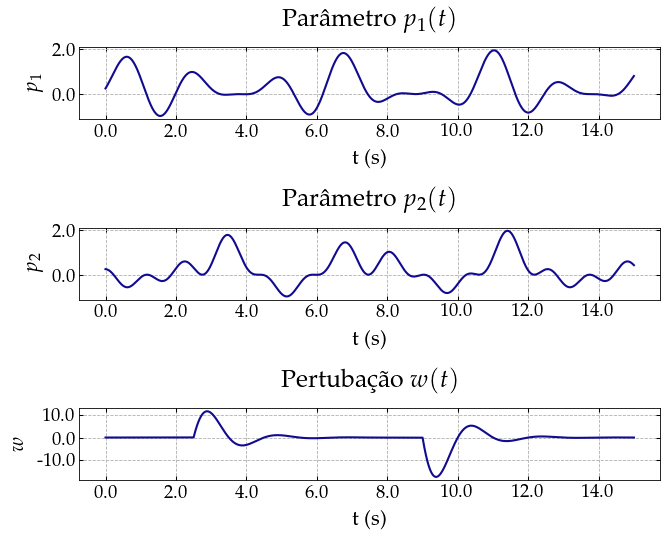

In [13]:
step = 1e-5
end_time = 15.
timepts = np.arange(0, end_time + step, step)
freq = 1

u1 = np.zeros((1, len(timepts)))
u2 = np.zeros((1, len(timepts)))

p1 = (0.5 + 1.5 * np.sin(-3 * timepts - np.pi)) * \
    (0.5 + 0.5 * np.sin(1.25 * timepts))

p2 = (0.5 + 1.5 * np.sin(1.5 * timepts - np.pi)) * \
    (0.5 + 0.5 * np.sin(4. * timepts))


# Parâmetros dos sinais
decay_rate = 1.2  # Taxa de decaimento
freq = .5  # Frequência da senoide
start_points = [2.5, 9.0]  # Pontos de início dos sinais
amplitudes = [20.0, -30.]  # Amplitudes dos sinais

# Inicializar o sinal composto
w = np.zeros_like(timepts)

# Gerar os sinais de acordo com os parâmetros
for start, amplitude in zip(start_points, amplitudes):
  # Tempo deslocado (somente após 'start')
  shifted_timepts = np.maximum(timepts - start, 0)
  signal = amplitude * np.exp(-decay_rate * shifted_timepts) * \
      np.sin(2 * np.pi * freq * shifted_timepts)

  # Somar ao sinal composto
  w += signal

# # Normalizar para energia limitada (se necessário)
# w /= np.sqrt(np.sum(w**2) * step)

fig, axs = plt.subplots(3, 1, figsize=(10, 7.5))
plt.subplots_adjust(wspace=0.25, hspace=1.5)

plot_utils.set_subplot(
    axs[0],
    timepts, p1,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)

plot_utils.set_subplot(
    axs[1],
    timepts, p2,
    't (s)',
    '$p_2$',
    'Parâmetro $p_2(t)$',
)

plot_utils.set_subplot(
    axs[2],
    timepts, w.reshape(-1, 1),
    't (s)',
    '$w$',
    'Pertubação $w(t)$',
)

plt.tight_layout()

In [14]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u1, u2, p1, p2, w,],
    X0=[2., 2.]
)

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 2))
plt.subplots_adjust(wspace=0.15, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    t, y[0],
    'Tempo (s)',
    '$x_1$',
    'Estado $x_1(t)$',
)

plot_utils.set_subplot(
    axs[1],
    t, y[1],
    'Tempo (s)',
    '$x_2$',
    'Estado $x_2(t)$',
)

plt.tight_layout()

In [16]:
def generate_binary_pairs(p):
  r = 2 ** p
  elements = list(range(r))
  result = []

  for i in elements:
    bin_i = tuple(map(int, f"{i:0{p}b}"))
    result.append([(bin_i, bin_i)])
    for j in elements:
      if i < j:
        bin_j = tuple(map(int, f"{j:0{p}b}"))
        result.append([(bin_i, bin_j), (bin_j, bin_i)])

  return result

In [17]:
def nearest_power_of_two(binary_tuple):
  decimal_value = sum(bit * (2 ** idx)
                      for idx, bit in enumerate(reversed(binary_tuple)))
  if decimal_value == 0:
    return 0
  previous_power = 2 ** (decimal_value.bit_length() - 1)
  return int(np.log2(previous_power))


# Example usage
binary_tuple = (0, 0)  # Represents the number 3
print(nearest_power_of_two(binary_tuple))  # Output: 1

0


In [21]:
def He(M): return M + M.T


p_bounds = np.array([[min(p1), max(p1)],
                     [min(p2), max(p2)]])

matrix_utils.show_matrix(p_bounds, 'Pbounds')
φ_bounds = [4.51, 4.11]
u0 = np.array([1., 2.])

nx = 2
nu = 2
nw = 1
nz = 2

B2 = list(itertools.product([0, 1], repeat=nz))
B2plus = [(0, 0), (0, 1), (1, 1)]


A = {}
B = {}
E = {}

for i in B2:
  p = [p_bounds[0][i[0]], p_bounds[1][i[1]]]
  A[i] = cp.Parameter((nx, nx), name=f'A[{i}]', value=get_A(p))
  B[i] = cp.Parameter((nx, nu), name=f'B[{i}]', value=get_B(p))
  E[i] = cp.Parameter((nx, nw), name=f'E[{i}]', value=get_E(p))

h = 10e-3
ε = 0.1

e = {}
_es = np.eye(nx)
_ef = np.zeros((nx, 6 * nx))
e[1] = np.block([[_es, _ef, np.zeros((nx, nu + nw))]])
e[7] = np.block([[_ef, _es, np.zeros((nx, nu + nw))]])

for i in range(2, 7):
  e[i] = np.block([[np.zeros((nx, nx * (i - 1))),
                    np.eye(nx),
                    np.zeros((nx, nx * (7 - i))),
                    np.zeros((nx, nu + nw))]])


e[8] = np.block([[np.zeros((nu,  7 * nx)), np.eye(nu), np.zeros((nu, nw))]])
e[9] = np.block([[np.zeros((nw,  7 * nx)), np.zeros((nw, nu)), np.eye(nw)]])


Ptil = {}
Stil = {}
Mtil = {}
for i in B2:
  Ptil[i] = cp.Variable((nx, nx), symmetric=True)
  Stil[i] = cp.Variable((nx, nx), symmetric=True)
  Mtil[i] = cp.Variable((nx, nx))

Ktil = {}

for i in B2:
  Ktil[i] = cp.Variable((nu, nx), name=f'K[{i}]')

Qtil = cp.Variable((nx, nx), PSD=True)
Rtil = cp.Variable((nx, nx), PSD=True)
Ξtil = cp.Variable((nx, nx), PSD=True)
Ψtil = cp.Variable((nx, nx), PSD=True)
Gcal = cp.Variable((nu, nx))
ℵ = cp.Variable((nu, nu), diag=True)
γ = cp.Variable(pos=True)


X = cp.Variable((nx, nx))
Y1til = cp.Variable((2 * nx, 2 * nx))
Y2til = cp.Variable((2 * nx, 2 * nx))

Rcal = cp.bmat([[Rtil, np.zeros((nx, nx))],
                [np.zeros((nx, nx)), 3. * Rtil]])

N = e[1].T + ε * e[2].T + ε * e[3].T

Π = np.bmat([[e[1] - e[3]],
             [e[1] + e[3] - 2 * e[5]],
             [e[3] - e[4]],
             [e[3] + e[4] - 2 * e[6]]])

κ0 = cp.bmat([[e[2]], [e[1] - e[4]]])

κ1 = {}
κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

constraints = []

for i in B2:
  Pcal = cp.bmat([[Ptil[i], Mtil[i]],
                  [Mtil[i].T, Stil[i]]])
  constraints += [Pcal >> 0]
  constraints += [Ptil[i] >> 0]


def get_Λ(i, j):
  Pcal = cp.bmat([[Ptil[i], Mtil[i]],
                  [Mtil[i].T, Stil[i]]])
  Ytil = A[i] @ X @ e[1] - X @ e[2] + \
      B[i] @ Ktil[j] @ e[3] + B[i] @ Ktil[j] @ e[7] - \
      B[i] @ ℵ @ e[8] + E[i] @ e[9]

  k = nearest_power_of_two(i)

  Θtil = {}
  Θtil['0'] = 2 * (κ1['0'].T @ Pcal @ κ0) + e[1].T @ Qtil @ e[1] - \
      e[4].T @ Qtil @ e[4] + h ** 2 * e[2].T @ Rtil @ e[2] - \
      e[7].T @ Ξtil @ e[7] + He(N @ Ytil) + e[8].T @ Gcal @ e[1] + \
      κ1['0'].T @ (φ_bounds[k] * Pcal) @ κ1['0'] - \
      γ * e[9].T @ e[9] + 2 * e[8].T @ ℵ @ e[8]

  Θtil['h'] = 2 * (κ1['h'].T @ Pcal @ κ0) + e[1].T @ Qtil @ e[1] - \
      e[4].T @ Qtil @ e[4] + h ** 2 * e[2].T @ Rtil @ e[2] - \
      e[7].T @ Ξtil @ e[7] + He(N @ Ytil) + e[8].T @ Gcal @ e[1] + \
      κ1['h'].T @ (φ_bounds[k] * Pcal) @ κ1['h'] - \
      γ * e[9].T @ e[9] + 2 * e[8].T @ ℵ @ e[8]

  Φtil = {}

  Φtil1 = cp.bmat([[Rcal, np.zeros((2 * nx, 2 * nx))],
                   [np.zeros((2 * nx, 2 * nx)), Rcal]])
  Φtil2 = cp.bmat([[Rcal, Y2til],
                   [Y2til.T, np.zeros((2 * nx, 2 * nx))]])
  Φtil3 = cp.bmat([[np.zeros((2 * nx, 2 * nx)), Y1til], [Y1til.T, Rcal]])

  Φtil['0'] = Φtil1 + Φtil2
  Φtil['h'] = Φtil1 + Φtil3

  Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
  Γ1_12 = Π.T @ cp.bmat([[Y1til.T], [np.zeros((2 * nx, 2 * nx))]])
  Γ1_13 = e[3].T @ X
  Γ1_15 = e[1].T @ X

  Γ1_21 = Γ1_12.T
  Γ1_22 = - Rcal
  Γ1_23 = np.zeros((2 * nx, nx))
  Γ1_25 = np.zeros((2 * nx, nx))

  Γ1_31 = Γ1_13.T
  Γ1_32 = Γ1_23.T
  Γ1_33 = - Ψtil
  Γ1_35 = np.zeros((nx, nx))

  Γ1_51 = Γ1_15.T
  Γ1_52 = Γ1_25.T
  Γ1_53 = Γ1_35.T
  Γ1_55 = - np.eye(nx)

  Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13, Γ1_15],
                [Γ1_21, Γ1_22, Γ1_23, Γ1_25],
                [Γ1_31, Γ1_32, Γ1_33, Γ1_35],
                [Γ1_51, Γ1_52, Γ1_53, Γ1_55]])

  Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
  Γ2_12 = Π.T @ cp.bmat([[Y1til.T], [np.zeros((2 * nx, 2 * nx))]])
  Γ2_13 = e[3].T @ X
  Γ2_15 = e[1].T @ X

  Γ2_21 = Γ2_12.T
  Γ2_22 = - Rcal
  Γ2_23 = np.zeros((2 * nx, nx))
  Γ2_25 = np.zeros((2 * nx, nx))

  Γ2_31 = Γ2_13.T
  Γ2_32 = Γ2_23.T
  Γ2_33 = - Ψtil
  Γ2_35 = np.zeros((nx, nx))

  Γ2_51 = Γ2_15.T
  Γ2_52 = Γ2_25.T
  Γ2_53 = Γ2_35.T
  Γ2_55 = - np.eye(nx)

  Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13, Γ2_15],
                [Γ2_21, Γ2_22, Γ2_23, Γ2_25],
                [Γ2_31, Γ2_32, Γ2_33, Γ2_35],
                [Γ2_51, Γ2_52, Γ2_53, Γ2_55]])

  return Γ1, Γ2


binary_pairs = generate_binary_pairs(nz)

for pairs in binary_pairs:
  LMI_SUM = {}
  LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

  print(pairs)

  for pair in pairs:
    Λ = {}
    Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
    LMI_SUM['0'] += Λ['0']
    LMI_SUM['h'] += Λ['h']

  constraints += [LMI_SUM['0'] << 0]
  constraints += [LMI_SUM['h'] << 0]


for i in B2:
  for j in B2:
    LMISAT_11 = e[1].T @ Ptil[i] @ e[1]
    LMISAT_12 = (e[3] + e[7]).T @ (Ktil[j] - Gcal).T
    LMISAT_21 = LMISAT_12.T
    LMISAT_22 = u0 ** 2 * np.eye(nu)

    LMISAT = cp.bmat([[LMISAT_11, LMISAT_12],
                      [LMISAT_21, LMISAT_22]])

    constraints += [LMISAT >= 0]


constraints += [ℵ >> 0]

# Define the optimization problem
# obj = cp.Minimize(0.)
obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + γ)
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
Ξ, Θ, K, Xinv = None, None, {}, None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  Xinv = np.linalg.inv(X.value)

  Ξ = Xinv.T @ Ξtil.value @ Xinv
  Ψ = np.linalg.inv(Ψtil.value)

  for i in B2:
    P = Xinv.T @ Ptil[i].value @ Xinv
    K[i] = Ktil[i].value @ Xinv
    # matrix_utils.show_matrix(P, f'P{i}')

  for i in B2:
    matrix_utils.show_matrix(K[i], f'K{i}')

  matrix_utils.show_matrix(Ξ, 'Ξ')
  matrix_utils.show_matrix(Ψ, 'Ψ')

  print('γ = ', γ.value)
else:
  print('The problem is not feasible')

Pbounds =
    ┌                     ┐
    │ -9.64e-01  1.93e+00 │
    │ -9.80e-01  1.98e+00 │
    └                     ┘

[((0, 0), (0, 0))]
[((0, 0), (0, 1)), ((0, 1), (0, 0))]
[((0, 0), (1, 0)), ((1, 0), (0, 0))]
[((0, 0), (1, 1)), ((1, 1), (0, 0))]
[((0, 1), (0, 1))]
[((0, 1), (1, 0)), ((1, 0), (0, 1))]
[((0, 1), (1, 1)), ((1, 1), (0, 1))]
[((1, 0), (1, 0))]
[((1, 0), (1, 1)), ((1, 1), (1, 0))]
[((1, 1), (1, 1))]
Optimal value: 484.98316292245806

K(0, 0) =
    ┌                     ┐
    │  6.54e-01  8.43e-03 │
    │ -2.41e-01  2.05e+00 │
    └                     ┘

K(0, 1) =
    ┌                    ┐
    │ 6.54e-01  8.26e-03 │
    │ 3.21e+00  1.44e+00 │
    └                    ┘

K(1, 0) =
    ┌                     ┐
    │  5.95e-01  8.32e-03 │
    │ -2.53e-01  2.15e+00 │
    └                     ┘

K(1, 1) =
    ┌                    ┐
    │ 6.02e-01  8.68e-03 │
    │ 2.01e+00  1.45e+00 │
    └                    ┘

Ξ =
    ┌                    ┐
    │ 6.95e+02  9.81e+00 │
  

In [22]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'p1_hat', 'p2_hat',
                'x1', 'x2', 'p1', 'p2'],
        outputs=['n', 'x1', 'x2', 'p1', 'p2']
    )

  def etm_update(self, t, n, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = self.last_sampled_states
    e = x_hat - x
    Γ = x.T @ self.Ψ @ x - e.T @ self.Ξ @ e
    n_dot = -self.λ * n + Γ
    return [n_dot]

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p_hat = u[2:4]
    x = np.array(u[4:6]).reshape(-1, 1)
    p = u[6:8]

    new_event = False

    if (t >= self.next_sampling_time):
      print(f'Sampling Time: {t:.3f}')
      e = x_hat - x
      Γ = x.T @ self.Ψ @ x - e.T @ self.Ξ @ e
      new_event = n[0] + self.θ * Γ < 0
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x_hat
    # p_to_send = p_hat

    if new_event or t == 0.:
      x_to_send = x
    p_to_send = p

    ans = [n[0], x_to_send[0][0], x_to_send[1][0],
           p_to_send[0], p_to_send[1]]
    return np.array(ans)

In [23]:

class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = np.zeros((1, nx + nz))[0]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2', 'p1', 'p2'],
        outputs=['x1_hat', 'x2_hat', 'p1_hat', 'p2_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'p1_hat', 'p2_hat'],
        outputs=['u1', 'u2'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p_hat = u[2:4]
    mins = p_bounds[:, 0]
    maxs = p_bounds[:, 1]

    # Normalização
    p_norm = (p_hat - mins) / (maxs - mins)

    u = np.zeros((2, 1))
    for j in B2:
      for i, b in enumerate(j):
        Kj = K[j]
        if b == 0:
          u[i, 0] += ((1. - p_norm[i]) * Kj[i, :] @ x_hat)[0]
        else:
          u[i, 0] += (p_norm[i] * Kj[i, :] @ x_hat)[0]

    return sat(u, u0)

In [24]:
# etm = StaticETM('etm', Ξ, Θ, h)
# etm = DynamicETM('etm', Θ, Ξ, 1e-2, 1e-1, h)
etm = DynamicETM('etm', Ψ, Ξ, 1e-2, 1e-4, h)
zoh = ZeroOrderHold()
controller = Controller(K)

closed_loop = ct.interconnect(
    (plant, etm.system, zoh.system, controller.system),
    connections=[
        # Connection between controller output and plant
        ['plant.u1', 'controller.u1'],
        ['plant.u2', 'controller.u2'],

        # Connection between ZOH and plant outputs to ETM
        ['etm.x1_hat', 'zoh.x1_hat'],
        ['etm.x2_hat', 'zoh.x2_hat'],
        ['etm.p1_hat', 'zoh.p1_hat'],
        ['etm.p2_hat', 'zoh.p2_hat'],

        ['etm.x1', 'plant.x1'],
        ['etm.x2', 'plant.x2'],

        # Connecting the ETM output to the ZOH
        ['zoh.x1', 'etm.x1'],
        ['zoh.x2', 'etm.x2'],
        ['zoh.p1', 'etm.p1'],
        ['zoh.p2', 'etm.p2'],

        # Connecting the ZOH output to the controller
        ['controller.x1_hat', 'zoh.x1_hat'],
        ['controller.x2_hat', 'zoh.x2_hat'],
        ['controller.p1_hat', 'zoh.p1_hat'],
        ['controller.p2_hat', 'zoh.p2_hat'],
    ],
    inplist=['plant.p1', 'plant.p2', 'etm.p1', 'etm.p2', 'plant.w'],
    name='closed-loop system',
    outlist=['etm.n', 'plant.x1', 'plant.x2',
             'controller.u1', 'controller.u2'],
    outputs=['n', 'x1', 'x2', 'u1', 'u2']
)

print(closed_loop)

<InterconnectedSystem>: closed-loop system
Inputs (5): ['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]']
Outputs (5): ['n', 'x1', 'x2', 'u1', 'u2']
States (3): ['plant_x1', 'plant_x2', 'etm_n']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x7f4dea142160>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x7f4dea142200>


In [25]:
etm.event_times = [0.]

t, y = ct.input_output_response(
    sys=closed_loop, T=timepts,
    U=[p1, p2, p1, p2, w],
    X0=[2., 2., 0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step,
                      'first_step': step, 'atol': 1e-2, 'rtol': 1e-2},
)

inter_event_times = [0.]

for i in range(1, len(etm.event_times)):
  inter_event_times.append(
      etm.event_times[i] - etm.event_times[i-1])

Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.000
Sampling Time: 0.010
Sampling Time: 0.010
Sampling Time: 0.010
Sampling Time: 0.020
Sampling Time: 0.020
Sampling Time: 0.020
Sampling Time: 0.030
Sampling Time: 0.030
Sampling Time: 0.030
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.040
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.050
Sampling Time: 0.060
Sampling Time: 0.060
Event Time:  0.0600000000000077
Sampling Time: 0.060
Sampling Time: 0.060
Sampling Time: 0.060
Sampling Time: 0.060
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.070
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.080
Sampling Time: 0.090
Sa

In [40]:
%matplotlib qt

print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))

fig, axs = plt.subplots(figsize=(15, 3))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs,
    t, y[1],
    'Tempo (s)',
    '$\\eta(t)$',
    'Variável Dinâmica do ETM',
)

plt.tight_layout()

Número de Eventos Acionados:  285
Menor IET Obtido:  0.0
Máximo IET Obtido:  0.8600019999991948


In [41]:
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    t, y[1],
    'Tempo (s)',
    '$x_1(t)$',
    'Estado 1 da Planta',
)

plot_utils.set_subplot(
    axs[1],
    t, y[2],
    'Tempo (s)',
    '$x_2(t)$',
    'Estado 2 da Planta',
)

plt.tight_layout()

Número de Eventos Acionados:  285
Menor IET Obtido:  0.0
Máximo IET Obtido:  0.8600019999991948


In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
plt.subplots_adjust(wspace=0.25, hspace=.7)

plot_utils.set_subplot(
    axs[0],
    t, y[3],
    'Tempo (s)',
    'sat($u_1(t)$)',
    'Entrada 1 Saturada',
)

plot_utils.set_subplot(
    axs[1],
    t, y[4],
    'Tempo (s)',
    'sat($x_2(t)$)',
    'Entrada 2 Saturada',
)

plt.tight_layout()

In [43]:
fig, axs = plt.subplots(figsize=(15, 3))
plt.subplots_adjust(wspace=0.3, hspace=1.)

print(sum(inter_event_times))

plot_utils.set_stem(
    axs, [et for et in etm.event_times],
    [et * 1e3 for et in inter_event_times],
    xlabel='Tempo (s)', ylabel='ITEE ($ms$)',
    x_digits=2,
    x_min=0.,
    x_max=end_time,
    title='Inter. de Tempo entre Eventos')
plt.tight_layout()

15.000000000000002
